In [1]:
from comet_ml import Experiment

experiment = Experiment(project_name="igti-projeto-aplicado-leis", workspace="piantino")

COMET INFO: old comet version (1.0.55) detected. current: 1.0.56 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/piantino/igti-projeto-aplicado-leis/f9f1a933590a4ef786b36f8ccb67fd30



In [2]:
import pandas as pd

colunas = ['PROCESSO', 'ROTULO_MANUAL', 'LEI']

df = pd.read_csv('../data/leis.csv', header=0, sep=',', quotechar='"', usecols=colunas)

In [3]:
 df.head()

,PROCESSO,ROTULO_MANUAL,LEI
0,00039604720138240039,CDC,artigo 535
1,00039604720138240039,CDC,9656/1998
2,00039604720138240039,CDC,616/2012
3,00039604720138240039,CDC,artigo 535
4,00039604720138240039,CDC,9656/1998


Utitiza apenas label que contenham mais de 200 exemplos.

In [4]:
rotulos = ['EXP', 'BAN', 'OIG', 'DAN', 'SEG', 'CON', 'OIE']

df.loc[~df['ROTULO_MANUAL'].isin(rotulos), 'ROTULO_MANUAL'] = 'NONE'

In [5]:
groupby_rotulo = df.groupby('ROTULO_MANUAL')

groupby_rotulo[['LEI']].count().sort_values(['LEI'], ascending=False)

,LEI
ROTULO_MANUAL,
NONE,12213
EXP,11698
BAN,5046
OIG,4945
DAN,3778
CON,2781
SEG,2621
OIE,2037


In [6]:
df.shape

(45119, 3)

In [7]:
data = df.groupby(['PROCESSO', 'ROTULO_MANUAL', 'LEI']).size().unstack('LEI', fill_value=0)
data = data.reset_index()

data.head()

LEI,PROCESSO,ROTULO_MANUAL,1/1975,1/2012,100/2015,101/2010,10144/2002,10150/2000,1025/2009,10257/2001,...,artigo 974,artigo 975,artigo 977,artigo 98,artigo 982,artigo 988,artigo 99,artigo 991,artigo 996,artigo 998
0,00000012120028240050,CON,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00000032720118240033,CON,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,00000042920148240058,CON,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00000057320168240242,NONE,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00000110319958240053,NONE,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
y = data['ROTULO_MANUAL'].values
y.shape

(4568,)

In [9]:
df1 = data.iloc[:,2:].copy()
df1.head()

LEI,1/1975,1/2012,100/2015,101/2010,10144/2002,10150/2000,1025/2009,10257/2001,104/1990,1060/1950,...,artigo 974,artigo 975,artigo 977,artigo 98,artigo 982,artigo 988,artigo 99,artigo 991,artigo 996,artigo 998
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
x = df1.values
x.shape

(4568, 845)

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)

import collections

print(collections.Counter(y_train))
print(collections.Counter(y_test))

Counter({'NONE': 1037, 'EXP': 473, 'OIG': 389, 'BAN': 389, 'SEG': 306, 'OIE': 293, 'DAN': 278, 'CON': 261})
Counter({'NONE': 381, 'OIG': 155, 'EXP': 147, 'BAN': 130, 'SEG': 88, 'CON': 87, 'DAN': 82, 'OIE': 72})


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

text_clf = Pipeline([
    ('clf', clf)
])

text_clf.fit(x , y)

Pipeline(memory=None,
     steps=[('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

Testando o modelo.

In [13]:
y_pred = text_clf.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.851138353765324

In [14]:
experiment.log_metric("accuracy", accuracy)

In [21]:
from sklearn import metrics

metrics_dict = {}

for label in result.keys():
    for metric in result[label].keys():
        metrics_dict[label + '-' + metric] = str(result[label][metric])

experiment.log_metrics(metrics_dict)

In [22]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         BAN       0.85      0.81      0.83       130
         CON       0.91      0.77      0.83        87
         DAN       0.87      0.73      0.79        82
         EXP       0.89      0.93      0.91       147
        NONE       0.77      0.94      0.85       381
         OIE       0.95      0.53      0.68        72
         OIG       0.93      0.90      0.92       155
         SEG       0.97      0.75      0.85        88

   micro avg       0.85      0.85      0.85      1142
   macro avg       0.89      0.80      0.83      1142
weighted avg       0.86      0.85      0.85      1142



In [23]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)

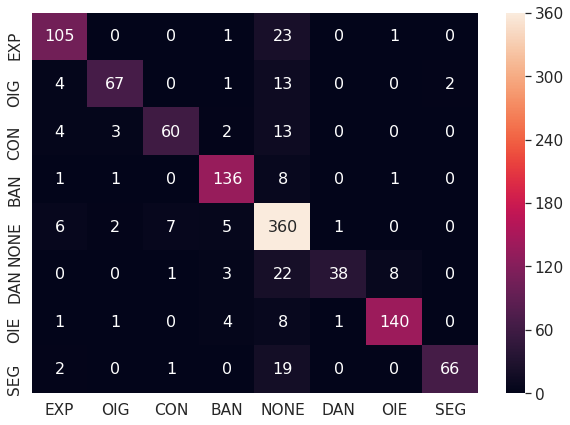

In [25]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = set(y_test)
      
df_cm = pd.DataFrame(cnf_matrix, range(len(labels)), range(len(labels)))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='g', annot_kws={"size": 16})

In [26]:
features = list(data.columns.values)
del features[0:2]

len(features)

845

In [27]:
df_sample = pd.DataFrame(columns=features)
df_sample = df_sample.append({'artigo 1018': 1}, ignore_index=True)
df_sample = df_sample.fillna(0)

df_sample

,1/1975,1/2012,100/2015,101/2010,10144/2002,10150/2000,1025/2009,10257/2001,104/1990,1060/1950,...,artigo 974,artigo 975,artigo 977,artigo 98,artigo 982,artigo 988,artigo 99,artigo 991,artigo 996,artigo 998
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
y_pred = text_clf.predict(df_sample)

y_pred

array(['EXP'], dtype=object)

In [29]:
from sklearn.externals import joblib

joblib.dump(features, '../modelos/Features-Leis.pkl', compress = 1)
joblib.dump(clf, '../modelos/Modelo-Leis.pkl', compress = 1) 

['../modelos/Modelo-Leis.pkl']

In [30]:
experiment.log_asset('../modelos/Features-Leis.pkl')
experiment.log_asset('../modelos/Modelo-Leis.pkl')

{'web': 'https://www.comet.ml/api/asset/download?assetId=f634213a064340139bc4dfeb2f7d9ae3&experimentKey=f9f1a933590a4ef786b36f8ccb67fd30',
 'api': 'https://www.comet.ml/api/rest/v1/asset/get-asset?assetId=f634213a064340139bc4dfeb2f7d9ae3&experimentKey=f9f1a933590a4ef786b36f8ccb67fd30'}

In [31]:
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/piantino/igti-projeto-aplicado-leis/f9f1a933590a4ef786b36f8ccb67fd30
COMET INFO:   Metrics:
COMET INFO:                        BAN: {'precision': 0.8536585365853658, 'recall': 0.8076923076923077, 'f1-score': 0.8300395256916996, 'support': 130}
COMET INFO:               BAN-f1-score: 0.8300395256916996
COMET INFO:              BAN-precision: 0.8536585365853658
COMET INFO:                 BAN-recall: 0.8076923076923077
COMET INFO:                BAN-support: 130
COMET INFO:                        CON: {'precision': 0.9054054054054054, 'recall': 0.7701149425287356, 'f1-score': 0.8322981366459626, 'support': 87}
COMET INFO:               CON-f1-score: 0.8322981366459626
COMET INFO:              CON-precision: 0.9054054054054054
COMET INFO:                 CON-recall: 0.7701149425287356
COMET INFO:                CON-support: 87
COMET INFO:         